In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
import torch.nn as nn
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss, L1Loss
import random
import matplotlib.pyplot as plt

#### Read in data

In [2]:
data = pd.read_csv("data/combined_data_normalized.csv")
data.head()

gameId  playId  yardsToGo  yardlineSide  yardlineNumber  gameClock  \
0  2022100908    3537        1.0             0            0.82   0.524444   
1  2022100908     619        1.0             0            0.30   0.324444   
2  2022100908    3731        1.0             1            0.38   0.314444   
3  2022100908    1821        1.0             0            0.64   0.077778   
4  2022100908    2392        1.0             1            0.52   0.697778   

   preSnapHomeScore  preSnapVisitorScore  passLength  penaltyYards  ...  \
0          0.875000             0.291667        0.30           0.0  ...   
1          0.000000             0.000000        0.00           0.0  ...   
2          0.875000             0.291667        0.35           0.0  ...   
3          0.416667             0.000000        0.00           0.0  ...   
4          0.541667             0.000000        0.00           0.0  ...   

   down_1  down_2  down_3  down_4  quarter_1  quarter_2  quarter_3  quarter_4  \
0       1       0       0       0          0          0          0          1   
1       1       0       0       0          1          0          0          0   
2       1       0       0       0          0          0          0          1   
3       1       0       0       0          0          1          0          0   
4       1       0       0       0          0          0          1          0   

   quarter_5  homeTeamPointDifferential  
0          0                   0.583333  
1          0                   0.000000  
2          0                   0.583333  
3          0                   0.416667  
4          0                   0.541667  

[5 rows x 37 columns]

In [3]:
data.columns

Index(['gameId', 'playId', 'yardsToGo', 'yardlineSide', 'yardlineNumber',
       'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'passLength',
       'penaltyYards', 'prePenaltyPlayResult', 'playResult',
       'playNullifiedByPenalty', 'absoluteYardlineNumber', 'passProbability',
       'flagsCount', 'homeTeamBall', 'offenseFormation_EMPTY',
       'offenseFormation_I_FORM', 'offenseFormation_JUMBO',
       'offenseFormation_PISTOL', 'offenseFormation_SHOTGUN',
       'offenseFormation_SINGLEBACK', 'offenseFormation_WILDCAT',
       'passResult_C', 'passResult_R', 'winningTeamIndicator', 'down_1',
       'down_2', 'down_3', 'down_4', 'quarter_1', 'quarter_2', 'quarter_3',
       'quarter_4', 'quarter_5', 'homeTeamPointDifferential'],
      dtype='object')

In [4]:
gameIds = data.gameId.unique()
random.seed(42)
random.shuffle(gameIds)
test_games = gameIds[:int(len(gameIds)*0.2)]
train_games = gameIds[int(len(gameIds)*0.2):]

In [5]:
train = data[data["gameId"].isin(train_games)]
test = data[data["gameId"].isin(test_games)]

X_train = train.drop(['winningTeamIndicator'], axis=1)
X_test = test.drop(['winningTeamIndicator'], axis=1)
y_train = train['winningTeamIndicator']
y_test = test['winningTeamIndicator']

#### Recurrent Neural Network

In [69]:
class NFLGameDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.uniqueGameIds = self.features['gameId'].unique()

    def __len__(self):
        return len(self.features['gameId'].unique())

    def __getitem__(self, idx):
        game_id = self.uniqueGameIds[idx]
        game_data = self.features[self.features['gameId'] == game_id]
        game_data = game_data.sort_values(by="playId")
        game_labels = self.labels.loc[game_data.index]
        
        # Convert DataFrame row to torch Tensor
        game_data_tensor = torch.tensor(game_data.drop(['gameId', 'playId'], axis=1).values).float()
        game_label_tensor = torch.tensor(game_labels.values).float()
        
        return game_data_tensor, game_label_tensor

In [84]:
class SequenceNFLRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, bidirectional=False, dropout=0.5):
        super(SequenceNFLRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # RNN Layer
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                           bidirectional=bidirectional, dropout=dropout if num_layers > 1 else 0.0)
        
        # Fully connected layer
        direction = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * direction, output_size)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Forward pass through RNN
        output, (ht, ct) = self.rnn(x)
        
        # Apply dropout to the outputs of the RNN
        output = self.dropout(output)
        
        # Apply the fully connected layer to each timestep
        # Using output.contiguous().view(...) to ensure the view operation works as expected
        sequence_length = output.shape[1]
        output = torch.sigmoid(self.fc(output.contiguous().view(-1, output.shape[2])))
        
#         # Reshape to get the sequence output in the desired shape: [batch_size, sequence_length]
        output = output.view(-1, sequence_length)
        
        return output
    
    def evaluate(self, data_loader, loss_fn, device):
        self.eval() # Set the model to evaluation mode
        total_loss = 0
        total_correct = 0
        total_samples = 0
        
        with torch.no_grad(): # No need to track gradients during evaluation
            for inputs, targets in data_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self(inputs)
                weights = torch.linspace(5, 0.1, outputs.shape[1], device=device)*(outputs - 0.5)**2+1
                loss = loss_fn(outputs, targets)
                loss = loss*weights
                loss = loss.mean()
                total_loss += loss.item()
                preds = outputs.argmax(dim=1) # Assuming classification task for accuracy calculation
                preds = preds >= 0.5
                total_correct += (preds == targets).sum().item()
                total_samples += targets.size(1)
        
        avg_loss = total_loss / len(data_loader)
        accuracy = total_correct / total_samples
        
        return avg_loss, accuracy

In [85]:
def train_model(model, train_loader, test_loader, lr=0.001, epochs=10):
    # Check for available GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")

    # Move model to the designated device
    model.to(device)
    
    optimizer = Adam(model.parameters(), lr=lr)
    loss_function = L1Loss(reduction="none")

    for epoch in range(epochs):
        total_loss = 0
        model.train()
        for inputs, labels in train_loader:
            # Move data to the same device as the model
            inputs, labels = inputs.to(device), labels.to(device)
            
#             Adjust labels' shape for BCEWithLogitsLoss
#             labels = labels.float().unsqueeze(1)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            weights = torch.linspace(5, 0.1, outputs.shape[1], device=device)*(outputs - 0.5)**2+1
            loss = loss_function(outputs, labels)
            loss = loss*weights
            loss = loss.mean()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}')
        model.eval()
        test_loss, test_accuracy = model.evaluate(test_loader, loss_function, device)
        
        print(f'Epoch {epoch+1}/{epochs}, Test Loss: {test_loss}')
        print(f'Epoch {epoch+1}/{epochs}, Test Accuracy: {test_accuracy}')
        print("|================================================|")

In [86]:
# Prepare dataset instances
train_dataset = NFLGameDataset(X_train, y_train)
test_dataset = NFLGameDataset(X_test, y_test)

# DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)  # Use batch_size=1 for variable-length sequences
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model parameters
input_size = len(X_train.columns) - 2  # number of features, excluding gameId and playId
hidden_size = 64  # Can be modified
output_size = 1  # For binary classification
num_layers = 2  # Number of LSTM layers
bidirectional = False  # Use bidirectional LSTM
dropout = 0.1  # Dropout rate

# Instantiate and print your model
model = SequenceNFLRNN(input_size, hidden_size, output_size, num_layers, bidirectional, dropout)
print(model)

SequenceNFLRNN(
  (rnn): LSTM(34, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [87]:
train_model(model, train_loader, test_loader, epochs=50, lr=0.0002)

Training on device: cuda
Epoch 1/50, Loss: 0.5044846439033474
Epoch 1/50, Test Loss: 0.49723356189551177
Epoch 1/50, Test Accuracy: 0.514612954186414
|================================================|
Epoch 2/50, Loss: 0.49429999743032893
Epoch 2/50, Test Loss: 0.4847603208488888
Epoch 2/50, Test Accuracy: 0.514612954186414
|================================================|
Epoch 3/50, Loss: 0.47543610263308256
Epoch 3/50, Test Loss: 0.4536665313773685
Epoch 3/50, Test Accuracy: 0.514612954186414
|================================================|
Epoch 4/50, Loss: 0.4664113427247476
Epoch 4/50, Test Loss: 0.44774801311669526
Epoch 4/50, Test Accuracy: 0.514612954186414
|================================================|
Epoch 5/50, Loss: 0.45485167123308967
Epoch 5/50, Test Loss: 0.43336771097448135
Epoch 5/50, Test Accuracy: 0.514612954186414
|================================================|
Epoch 6/50, Loss: 0.448782024990528
Epoch 6/50, Test Loss: 0.4398503005504608
Epoch 6/50, Test

Epoch 47/50, Loss: 0.3636954847825776
Epoch 47/50, Test Loss: 0.371887402953925
Epoch 47/50, Test Accuracy: 0.514612954186414
|================================================|
Epoch 48/50, Loss: 0.3578154520567404
Epoch 48/50, Test Loss: 0.38355605414620153
Epoch 48/50, Test Accuracy: 0.514612954186414
|================================================|
Epoch 49/50, Loss: 0.3606531827821644
Epoch 49/50, Test Loss: 0.36463442555180303
Epoch 49/50, Test Accuracy: 0.514612954186414
|================================================|
Epoch 50/50, Loss: 0.3511687394129027
Epoch 50/50, Test Loss: 0.3791338119793821
Epoch 50/50, Test Accuracy: 0.514612954186414
|================================================|


In [88]:
test_iter = iter(test_loader)
model.cpu()

SequenceNFLRNN(
  (rnn): LSTM(34, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [119]:
def getOutputGraphs(test_iter, model):
    test_item = next(test_iter)
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    preds = model(test_item[0]).detach().numpy().squeeze()
    axs[0].plot([i+1 for i in range(len(preds))], (preds - 0.5)*2)
    axs[0].set_ylim(-1.1, 1.1)
    axs[0].set_xlabel("Play number")
    axs[0].set_ylabel("Away Team Win Chance (-) vs Home Team Win Chance (+)")
    axs[0].set_title("Model predictions after each play")
    
    axs[1].plot([i+1 for i in range(len(preds))], test_item[0][0, :, X_test.columns.drop(["gameId", "playId"]).get_loc("preSnapHomeScore")] * 24, label="Home Team Score")
    axs[1].plot([i+1 for i in range(len(preds))], test_item[0][0, :, X_test.columns.drop(["gameId", "playId"]).get_loc("preSnapVisitorScore")] * 24, label="Away Team Score")
    axs[1].set_ylim(-1, 47)
    axs[1].set_xlabel("Play Number")
    axs[1].set_ylabel("Score")
    axs[1].set_title("Home vs away team score during the game")
    axs[1].legend()

    plt.show()

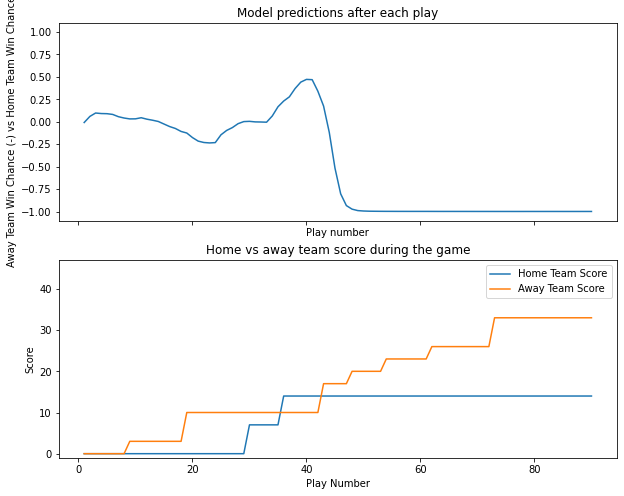

In [122]:
#Generates the predictions and score graphs for a random game in the test set
getOutputGraphs(test_iter, model)